Name of Members:

- __APA, GIUSIPPI MARIA II DEL ROSARIO__
- __OBEJERO, REY FERBS MAGALLON__
- __RAMIREZ, BENMAR SIM GREFALDA__
- __RAMOS, RONN PATRICK BICERA__

## I. Introduction

The dataset we chose for this machine project is the "Sports" dataset. 

Our project will have us go through the process of selecting a dataset, describing it, performing EDA, data preprocessing and cleaning, model training, HP tuning, model selection, and extracting insights from the data.

We aim to leverage the data from the soccer matches to preduct the number of goals that will be scored during the remaining playtime. The target of this project is regression as we aim to predict a continous outcome, which is the **number of goals to be scored** during the remaining time.

We will implement the use of machine learning and other techniques taught in class to build our predictive model.

## II. Description

The dataset is related to soccer matches and will be used to predict how many goals will be scored during the remaining match time. The dataset contains 10,000 such snapshots, each taken at a different, random point in time during a match. 

In the context of this dataset, a “snapshot” refers to a set of data points captured at a specific moment during a soccer match.

As for the collection process, it can be inferred that the data might have been collected in real-time during this soccer match, capturing various events and statistics at different timestamps. This data would allow for more accurate predictions of future events based on the current state of the match, and whether it is best to bet on over or under a certain number of goals.

There are only 7000 instances(rows) and 21 features(columns) in the dataset. Each of the features are statistics of both events for the home and away team.

### List of Variables

| **Variable Name** | **Description**|
|--------------------------------------|----------------|
|**uuid** | Snapshot’s unique ID|
|**current_minute** | Match’s current minute, including 15 min half-time|
|**home_score and away_score** | Home and away team’s goals.|
|**home_yellow_cards and away_yellow_cards**| Home and away team’s yellow cards.|
|**home_red_cards and away_red_cards**| Home and away team’s red cards.|
|**home_attacks and away_attacks**| Home and away team’s attempted attacks.|
|**home_dangerous_attacks and away_dangerous_attacks**| Home and away team’s dangerous attacks.|
|**home_corners and away_corners**| Home and away team’s awarded corners.|
|**home_off_target and away_off_target**| Home and away team’s off-target shots.|
|**home_on_target and away_on_target**| Home and away team’s on-target shots.|
|**home_possession and away_possession** |Home and away team’s ball possession %.|

## III. Modules

For this machine project, we will utilize the following Python libraries:

- `one`:
- `two`:
- `three`:
- `four`:

In [9]:
import csv
import h5py
import math
import os
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from neural_network import NeuralNetwork
from linear_regression import AnalyticalMethod, compute_RMSE
from linear_regression import PolyFitMethod
import pandas as pd
from scipy import misc
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import log_loss, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, cross_val_score, ParameterGrid
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import torch.optim as optim
import torch.nn as nn


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## IV. Data Cleaning

We will now be performing various methods of preprocessing and data cleaning to enhance the dataset's usability and suitability to our exploratory analysis and model training.

This is also to ensure that the dataset will be ready for use, which means we will be checking for missing values, duplicates, outliers and other errors. Making it so that the data is in its correct representation.

In [11]:
# Importing and reading the Sports.csv
sports = pd.read_csv("sports.csv")
sports.head()

,uuid,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,...,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
0,2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,...,26,4,1,4,0,4,6,48,52,1
1,869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,50,1
2,549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,62,38,4
3,287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,...,25,1,0,0,2,0,0,55,45,2
4,a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,...,46,1,1,0,3,4,4,45,55,0


**Checking for Missing Values**



The code here indentifies and prints the columns in our sports Dataframe that contain missing values, first one counts the total number of missing values in each column, and if the count is greater than zero it shows us the list.

This is an essential step, just so we can see if we have any columns that are missing data before we move on to other processes.

In [12]:
# Check each column for missing values
missing_values = sports.isnull().sum()

columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


**Checking for Duplicates**



This code identifies and removes duplicates rows in the sports DataFrame, it finds all the duplicate rows and seperates them and prints out the rows. Duplicates are removed from the original dataframe and will only keep the first occurence. 

In [13]:
# Find the duplicates
duplicate_uuids = sports.duplicated(keep=False)

# Create a dataframe for duplicates
duplicates = sports[duplicate_uuids]

# Display the rows with duplicates
print("Duplicate Entries:\n", duplicates)

# Removing the duplicates if detected in dataframe
if not duplicates.empty:
    sports = sports.drop_duplicates(keep='first')
    print("Duplicates removed. Dataset has {sports.shape[0]} rows.")
else:
    print("No duplicates found.")

Duplicate Entries:
 Empty DataFrame
Columns: [uuid, current_minute, home_score, away_score, home_yellow_cards, away_yellow_cards, home_red_cards, away_red_cards, home_attacks, away_attacks, home_dangerous_attacks, away_dangerous_attacks, home_corners, away_corners, home_off_target, away_off_target, home_on_target, away_on_target, home_possession, away_possession, final_delta]
Index: []

[0 rows x 21 columns]
No duplicates found.


**Other Cleaning Processes**

The first process replaces infinite values with NaN, which is for undefined data. Drops any columns where there are more than 50% values are missing, while the last checks for inconsistencies in the possession data, wherein it looks for home_possession and way_possession variables that do not equate to 100.

In [14]:
# Replacing any erroneous infinite values
sports = sports.replace([np.inf, -np.inf], np.nan)

# Dropping columns with more than 50% missing values
sports = sports.dropna(thresh=len(sports)*0.5, axis=1)

# Check for incorrect possession percentages
incorrect_possession_indices = sports[~(sports['home_possession'] + sports['away_possession'] == 100)].index

if len(incorrect_possession_indices) > 0:
    print("Found inconsistencies in possession data:")
    print(sports.loc[incorrect_possession_indices, ['home_possession', 'away_possession']])
else:
    print("Possession data is consistent.")

Found inconsistencies in possession data:
      home_possession  away_possession
72                 67               32
881                23               76
1084               77               22
1185               75               24
1421               33               66
1485               77               22
1950               71               28
1984               83               16
2415               30               69
2849               27               72
2895               78               21
2953               79               20
3222               31               68
3313               65               34
4065               25               74
4669               73               26
5302               78               21
5509               25               74
6299               73               26
6527               33               66
6660               72               27
6839               76               23


As you can see there are percentages that don't equate to 100, but the difference is neglible because it is only from 99 to 100 which won't cause much noise in the analysis. It isn't exactly necessary to remove it at this point of the dataset but is also another consideration we took to prepare the if ever the dataset grew larger.

**Data Type Checking**

Having appropriate data types for the values in the dataset is crucial to data analysis and model training. Luckily for us, the dataset we currently have has the appropriate values as all of the variables and their values are appropriate to their data type.

The importance of having correct data types is that we have the following:

Data Integrity,
Accuracy,
Efficiency,
Compatibility, 
and Reliability

In [15]:
# Printing all of the present data types
print("All data types present:\n", sports.dtypes)

All data types present:
 uuid                      object
current_minute             int64
home_score                 int64
away_score                 int64
home_yellow_cards          int64
away_yellow_cards          int64
home_red_cards             int64
away_red_cards             int64
home_attacks               int64
away_attacks               int64
home_dangerous_attacks     int64
away_dangerous_attacks     int64
home_corners               int64
away_corners               int64
home_off_target            int64
away_off_target            int64
home_on_target             int64
away_on_target             int64
home_possession            int64
away_possession            int64
final_delta                int64
dtype: object


### Outlier Detection and Treatment

Outliers can significantly impact statistical measures and model performance. In the context of our dataset, outliers might represent unusual game conditions, errors in data collection, or truly exceptional events. 

Surprisingly enough, there are no major outliers in our dataset, because in the dataset, varying values like attacks, cards, and accuracy are all subject to the team's playstyle and ability. 

**Our Approach**

But we performed winsorization on the dataset to make it robust against potential outliers in the future if ever there are any in the future, possibly when the dataset grows larger. By capping the data at specified percentiles we reduce the possible influed of these outliers. 

We also provided the before and after outlier treatment visualizations to identify the outliers (if there are any).

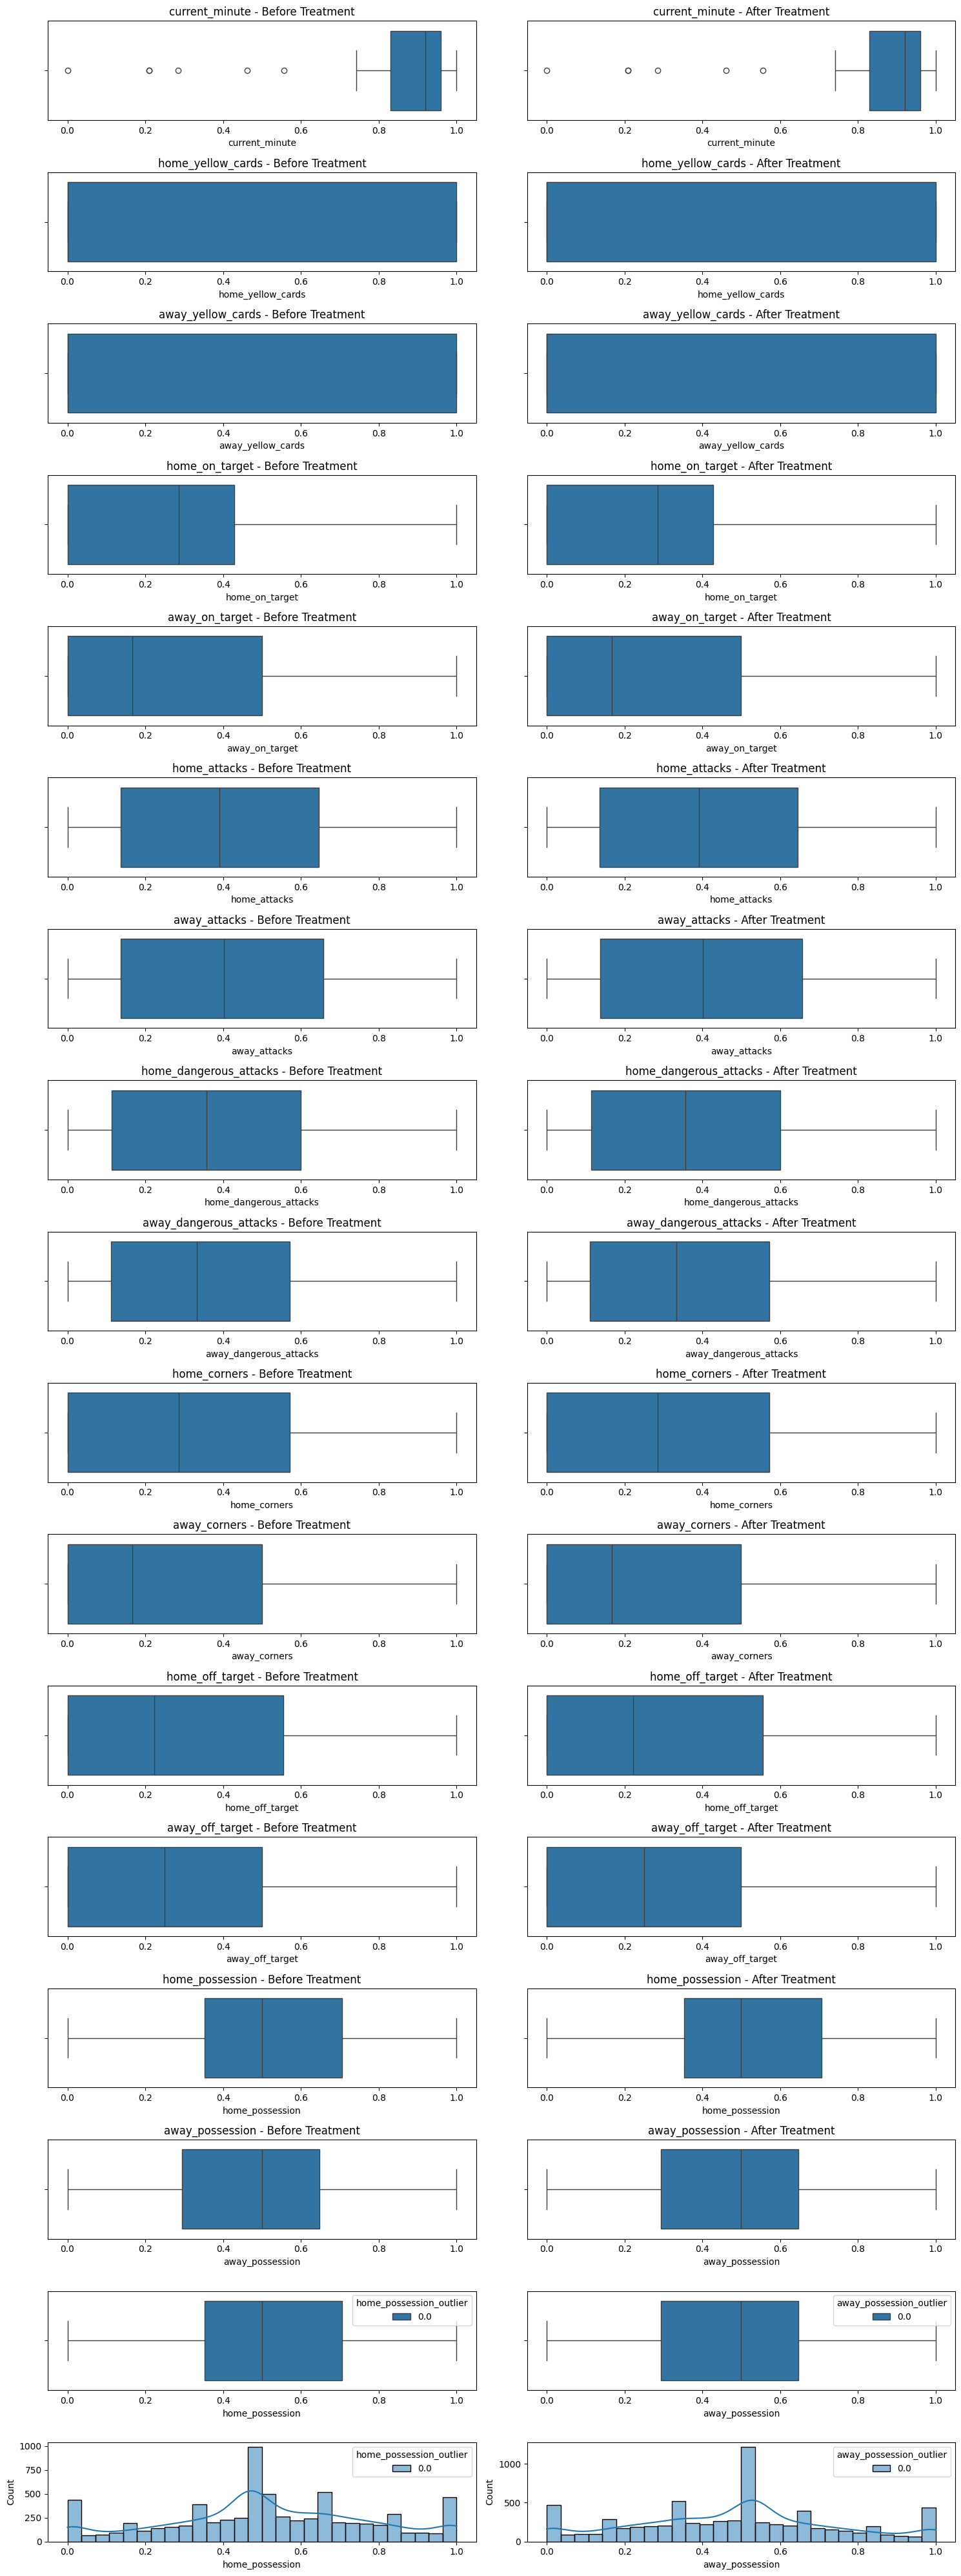

In [16]:
# Columns to check for outliers
outlier_columns = ['current_minute', 'home_yellow_cards', 'away_yellow_cards', 'home_on_target',
                   'away_on_target', 'home_attacks', 'away_attacks', 'home_dangerous_attacks',
                   'away_dangerous_attacks', 'home_corners', 'away_corners', 'home_off_target',
                   'away_off_target', 'home_possession', 'away_possession']

def winsorize(data, lower_percentile=5, upper_percentile=95):
    """Winsorizes data by capping values at specified percentiles."""
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return np.clip(data, lower_bound, upper_bound)

def truncate(data, upper_bound):
    """Truncates data by removing values exceeding the upper bound."""
    return data[data <= upper_bound]

def detect_possession_outliers(data, method='zscore', z_score_threshold=3, lower_bound=20, upper_bound=80):
    """
    Identifies outliers in home and away possession data using different methods.

    Args:
        data: Pandas DataFrame containing home_possession and away_possession columns.
        method: The outlier detection method to use ('zscore', 'percentile', 'domain').
        z_score_threshold: Threshold for Z-scores (used with 'zscore' method).
        lower_bound: Lower threshold for possession values (used with 'domain' method).
        upper_bound: Upper threshold for possession values (used with 'domain' method).

    Returns:
        A new DataFrame with additional columns indicating potential outliers.
    """
    home_possession = data['home_possession']
    away_possession = data['away_possession']

    if method == 'zscore':
        # Z-score method (not used for normalization)
        pass
    elif method == 'percentile':
        # Percentile-based method (not used for normalization)
        pass
    elif method == 'domain':
        # Domain knowledge-based method
        data['home_possession_outlier'] = np.where((home_possession < lower_bound) | (home_possession > upper_bound), True, False)
        data['away_possession_outlier'] = np.where((away_possession < lower_bound) | (away_possession > upper_bound), True, False)
    else:
        raise ValueError("Invalid outlier detection method. Choose 'zscore', 'percentile', or 'domain'.")

    return data

# Handle outliers for other columns
for col in outlier_columns:
    if col == 'current_minute':
        sports[col] = truncate(sports[col], 105)
    elif col.endswith('_cards'):
        sports[col] = winsorize(sports[col], upper_percentile=80)
    else:
        sports[col] = winsorize(sports[col])

# Choose a method for possession outliers and apply it
sports = detect_possession_outliers(sports.copy(), method='domain', lower_bound=20, upper_bound=80)  # Example: using domain-based method

# Calculate goals scored after current minute
def calculate_remaining_goals(row):
    total_goals = row['home_score'] + row['away_score']
    goals_so_far = total_goals - row['home_score'] - row['away_score']
    return total_goals - goals_so_far

sports['goals_remaining'] = sports.apply(calculate_remaining_goals, axis=1)

# Calculate additional features
epsilon = 1e-10  # Add a small number to avoid division by zero
sports['home_attack_efficiency'] = sports['home_score'] / (sports['home_attacks'] + epsilon)
sports['away_attack_efficiency'] = sports['away_score'] / (sports['away_attacks'] + epsilon)

sports['home_shot_conversion_rate'] = sports['home_score'] / (sports['home_on_target'] + sports['home_off_target'] + epsilon)
sports['away_shot_conversion_rate'] = sports['away_score'] / (sports['away_on_target'] + sports['away_off_target'] + epsilon)

sports['possession_differential'] = sports['home_possession'] - sports['away_possession']

# Select columns for normalization (excluding uuid)
columns_to_normalize = [col for col in sports.columns if col != 'uuid']

# Create a MinMaxScaler object (normalizes to -1 to 1 range)
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply normalization to selected columns
sports[columns_to_normalize] = scaler.fit_transform(sports[columns_to_normalize])

# Visualize distributions after outlier treatment and normalization
fig, axes = plt.subplots(nrows=len(outlier_columns) + 2, ncols=2, figsize=(15, 40))

for i, col in enumerate(outlier_columns):
    # Box plots
    sns.boxplot(data=sports, x=col, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} - Before Treatment')

    sns.boxplot(data=sports, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} - After Treatment')

# Visualize possession data with outliers
sns.boxplot(data=sports, x='home_possession', ax=axes[len(outlier_columns), 0], hue='home_possession_outlier')
sns.boxplot(data=sports, x='away_possession', ax=axes[len(outlier_columns), 1], hue='away_possession_outlier')

# Histograms for possession data with outliers
sns.histplot(data=sports, x='home_possession', kde=True, ax=axes[len(outlier_columns) + 1, 0], hue='home_possession_outlier')
sns.histplot(data=sports, x='away_possession', kde=True, ax=axes[len(outlier_columns) + 1, 1], hue='away_possession_outlier')

plt.tight_layout()
plt.show()


We did boxplots and histograms for all relevant variables and utilized truncation and winsorization. 

In our current case, there are no obvious outliers, because the initial data might not have contained extreme values that would significantly impact the results. There is also the idea of playstyle variations where the teams at different current_minutes would have varying possessions, attacks, or accuracy.

Despite this, still applying outlier detection methods still offers a safety net from future outliners. We also applied normalization to bring the features to a common scale between 0 and 1, this will help us ensure that there is feature scaling and improved algorithm performance from algorithms like such as neural networks and gradient descent.

### Data Transformation

**Feature Engineering**
`goals_remaining`: This is our target variable, representing the number of goals scored in the remaining time of the match.

Ratio of Attack to Goals

`home_attack_efficiency`: Measures the efficiency of the home team in converting attacks into goals.
`away_attack_efficiency`: Measures the efficiency of the away team in converting attacks into goals.

Ratio of Shots to Goals

`home_shot_conversion_rate`: Measures the efficiency of the home team in converting shots into goals.
`away_shot_conversion_rate`: Measures the efficiency of the away team in converting shots into goals.

In [17]:
# Calculate goals scored after current minute
def calculate_remaining_goals(row):
    total_goals = row['home_score'] + row['away_score']
    goals_so_far = total_goals - row['home_score'] - row['away_score']
    return total_goals - goals_so_far

sports['goals_remaining'] = sports.apply(calculate_remaining_goals, axis=1)

# Calculate additional features
sports['home_attack_efficiency'] = sports['home_score'] / sports['home_attacks']
sports['away_attack_efficiency'] = sports['away_score'] / sports['away_attacks']
sports['home_shot_conversion_rate'] = sports['home_score'] / (sports['home_on_target'] + sports['home_off_target'])
sports['away_shot_conversion_rate'] = sports['away_score'] / (sports['away_on_target'] + sports['away_off_target'])

print(sports['goals_remaining'].head())

0    0.347222
1    0.250000
2    0.000000
3    0.000000
4    0.125000
Name: goals_remaining, dtype: float64


**Dropping Features**

The uuid column is a unique identifier that does not provide any predictive information, therefore it's correct to drop it.

In [18]:
# Dropping irrelevant column
sports = sports.drop('uuid', axis=1)

**Correlation Matrix**

**Removal of Features**

## Exploratory Data Analysis

EDA is a critical step in any data analysis or machine learning project. It allows us to understand the data’s characteristics, identify patterns and relationships, detect anomalies, inform feature engineering, and check assumptions. For instance, EDA on the ‘Sports’ dataset will provide insights into the factors influencing the number of goals scored during the remaining playtime. These insights will guide our choice of regression model and help us engineer features that improve our model’s predictive performance. 

We can try to look at the average goals remaining for all the games, to have a general idea of it.

In [19]:
average_goals_remaining = sports['goals_remaining'].mean()

print(f"Average Goals Remaining: {average_goals_remaining}")

Average Goals Remaining: 0.16873809523809524


Here we will generate a history plot of the goals_remaining variable to visualize its distribution.

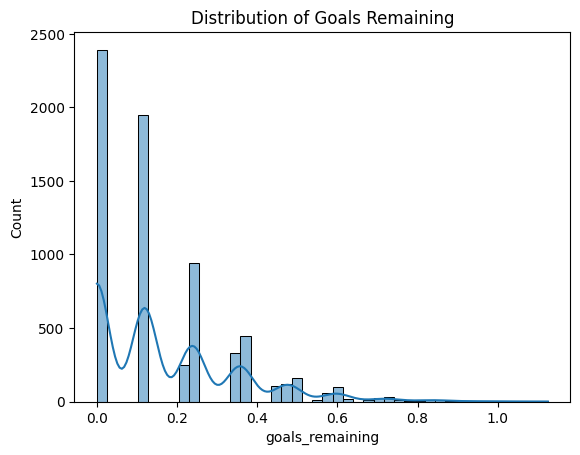

In [20]:
sns.histplot(sports['goals_remaining'], kde=True)
plt.title('Distribution of Goals Remaining')
plt.show()

Right-skewness for goals remaining indicates that while most matches have fewer goals remaining, there are some matches where a significantly higher number of goals are scored towards the end. This distribution suggests that matches can vary widely in the number of goals scored in the remaining time.

Below we can first visualize the home attack efficiency and shot conversion rate, here in the Kernel Density Estimate (KDE), it's basically a smoothed out version of the histogram so we can better see the distribution and probability density.

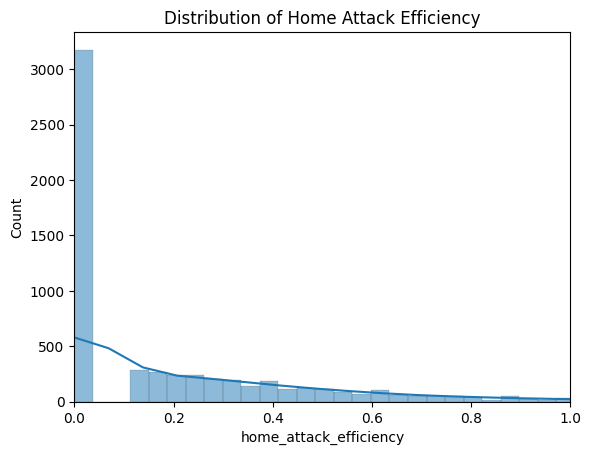

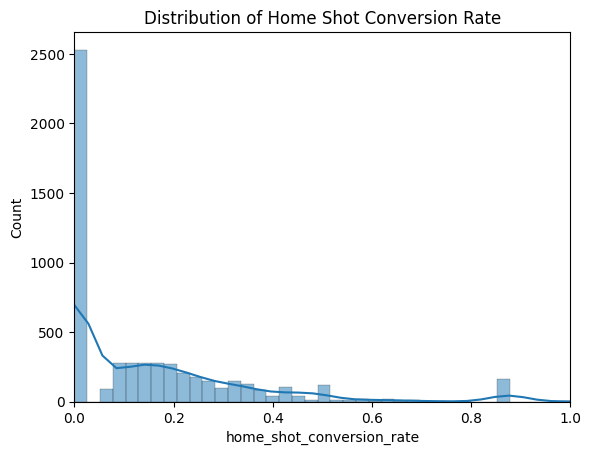

In [33]:
sns.histplot(sports['home_attack_efficiency'], kde=True)
plt.title('Distribution of Home Attack Efficiency')
plt.xlim(0, 1)  
plt.show()

sns.histplot(sports['home_shot_conversion_rate'], kde=True)
plt.title('Distribution of Home Shot Conversion Rate')
plt.xlim(0, 1) 
plt.show()


Here we can generate the away attack efficiency and away shot conversion rate. We see a significant difference in their KDE as well.

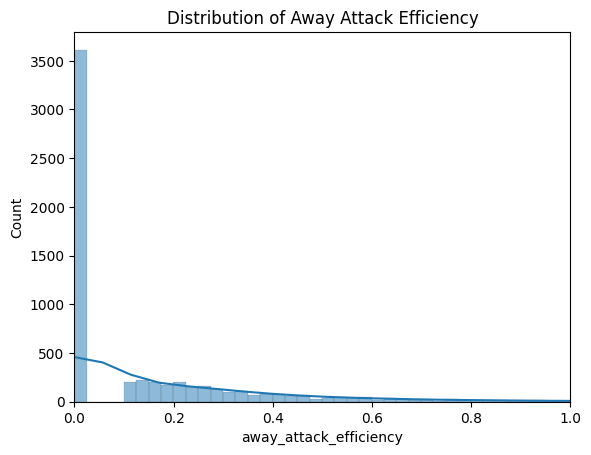

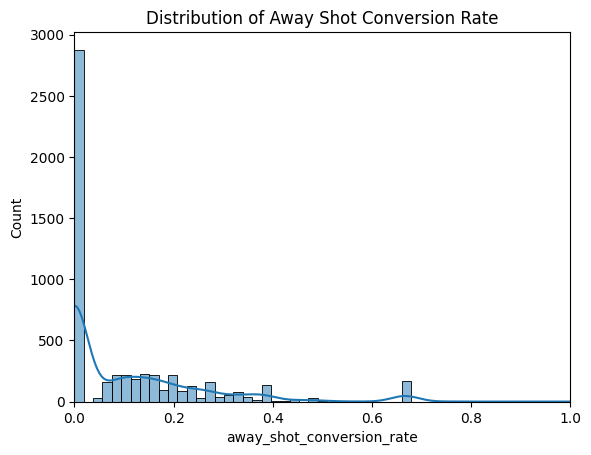

In [32]:
sns.histplot(sports['away_attack_efficiency'], kde=True)
plt.title('Distribution of Away Attack Efficiency')
plt.xlim(0, 1) 
plt.show()

sns.histplot(sports['away_shot_conversion_rate'], kde=True)
plt.title('Distribution of Away Shot Conversion Rate')
plt.xlim(0, 1) 
plt.show()

The features attack_efficiency and shot_conversion_rate for both teams are right-skewed. This means that most teams have lower values for these features, indicating that they are generally less efficient in converting attacks into goals. However, there are a few teams with very high values, suggesting that only a small number of teams achieve high efficiency in these areas.


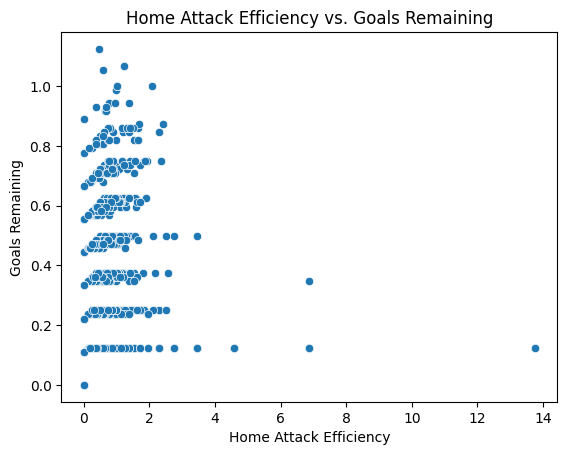

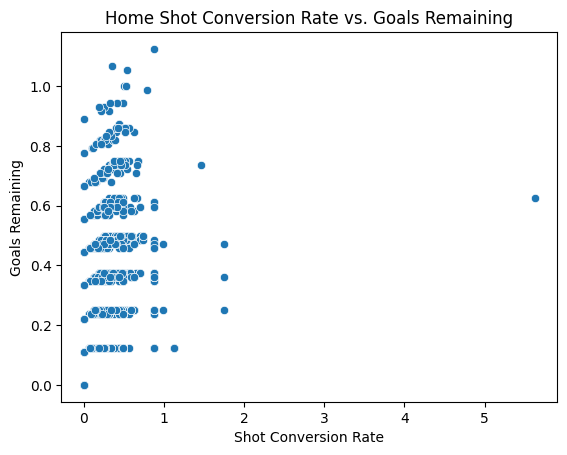

In [23]:
sns.scatterplot(x='home_attack_efficiency', y='goals_remaining', data=sports)
plt.title('Home Attack Efficiency vs. Goals Remaining')
plt.xlabel('Home Attack Efficiency')
plt.ylabel('Goals Remaining')
plt.show()

sns.scatterplot(x='home_shot_conversion_rate', y='goals_remaining', data=sports)
plt.title('Home Shot Conversion Rate vs. Goals Remaining')
plt.xlabel('Shot Conversion Rate')
plt.ylabel('Goals Remaining')
plt.show()

Since the goals remaining vary despite most teams having a low attack efficiency means that this variabile could be due to other factors influencing the number of goals remaining that are not captured by attack efficiency and shot conversion alone.

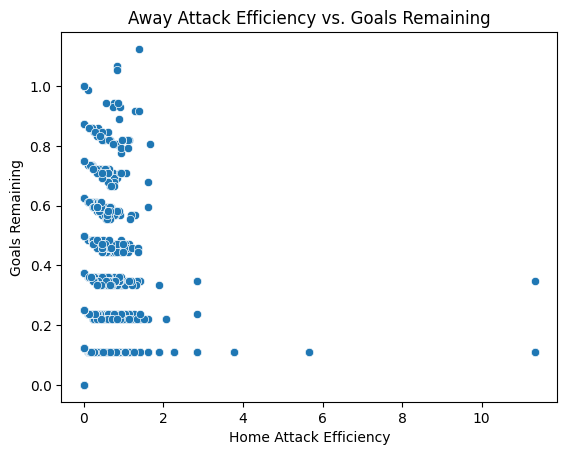

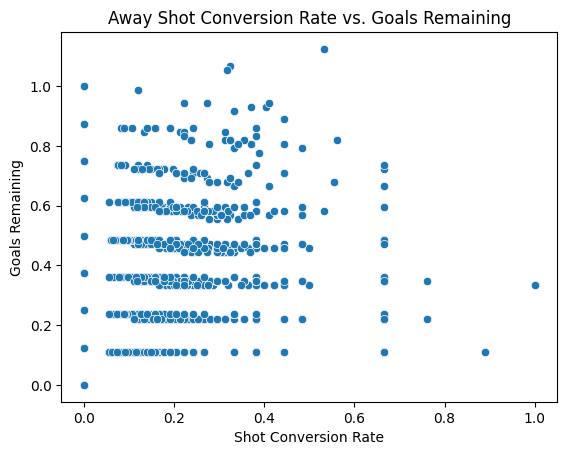

In [24]:
sns.scatterplot(x='away_attack_efficiency', y='goals_remaining', data=sports)
plt.title('Away Attack Efficiency vs. Goals Remaining')
plt.xlabel('Home Attack Efficiency')
plt.ylabel('Goals Remaining')
plt.show()


sns.scatterplot(x='away_shot_conversion_rate', y='goals_remaining', data=sports)
plt.title('Away Shot Conversion Rate vs. Goals Remaining')
plt.xlabel('Shot Conversion Rate')
plt.ylabel('Goals Remaining')
plt.show()

The same interpretation can be concluded with the away attack efficiency, but it now differs with the away shot conversion rate where the points are much more scattered but is still mostly right-skewed.

## Model Training

Model training is a crucial step in the machine learning pipeline. It involves learning the underlying patterns in the training data so that we can make predictions on unseen data. The goal is to find a model that generalizes well, meaning it accurately predicts the outcomes on new, unseen data based on the patterns it learned from the training data.

In this project, we trained several types of regression models on our 'Sports' dataset:

1. **Linear Regression**: This is a simple and commonly used type of regression that assumes a linear relationship between the input variables (x) and the single output variable (y). It can be used when the relationship between the input and output variables is approximately linear.

2. **Regression Trees (Decision Trees)**: This is a type of model that breaks down our dataset into smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes, which provide a clear interpretation of why the model is making certain predictions.

3. **Polynomial Regression**: This is a type of regression that models the relationship between the input variable (x) and the output variable (y) as an nth degree polynomial. Polynomial regression can model relationships between variables that aren't linear and can fit data with curves or slopes.

In [25]:
# Using untruncated data
# with open('sports.csv', 'r') as csv_file:
#     raw_data = csv.reader(csv_file)
#     next(csv_file)
#     X_sports = np.empty((0, 1), int)
#     y_sports = np.empty((0, 1), int)
#     for row in raw_data:
#         X_sports = np.vstack([X_sports, np.array([int(row[8])])])  # column for home attacks
#         y_sports = np.append(y_sports, np.array([int(row[10])]))    # column for home dangerous attacks

# Using truncated/cleaned data
X_sports = sports['home_attacks'].values.reshape(-1, 1)
y_sports = sports['home_dangerous_attacks'].values

print('Training data shape:', X_sports.shape)
print('Ground truth values shape:', y_sports.shape)

Training data shape: (7000, 1)
Ground truth values shape: (7000,)


Visualizing the data.

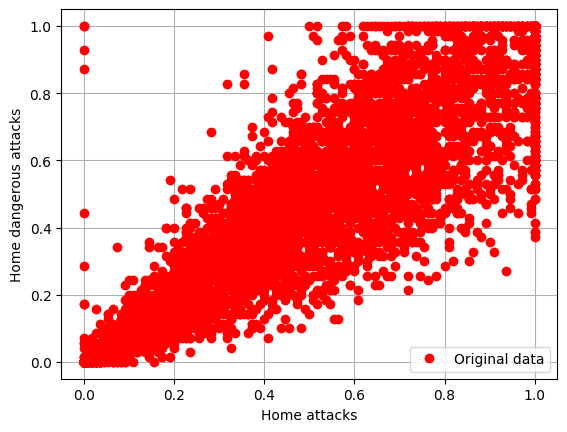

In [26]:
fig, ax = plt.subplots()
ax.plot(X_sports, y_sports, 'ro', label='Original data')

plt.ylabel('Home dangerous attacks')
plt.xlabel('Home attacks')
ax.legend()
plt.grid()
plt.show()

Train the model using gradient descent.

In [27]:
# For truncated/cleaned data
# model = SGDRegressor(eta0=1e-9, max_iter=200, penalty=None, learning_rate='constant', random_state=1, verbose=1)

# For untruncated data
model = SGDRegressor(eta0=1e-9, max_iter=200, learning_rate='optimal', random_state=1, verbose=1, alpha=0.001)

model.fit(X_sports, y_sports)


-- Epoch 1
Norm: 5556.52, NNZs: 1, Bias: 0.096570, T: 7000, Avg. loss: 99221178181589166718976.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2812.91, NNZs: 1, Bias: 0.024815, T: 14000, Avg. loss: 0.008332
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1883.10, NNZs: 1, Bias: -0.024485, T: 21000, Avg. loss: 0.008096
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1415.28, NNZs: 1, Bias: 0.018934, T: 28000, Avg. loss: 0.007974
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1133.65, NNZs: 1, Bias: 0.015605, T: 35000, Avg. loss: 0.007907
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 945.50, NNZs: 1, Bias: 0.014711, T: 42000, Avg. loss: 0.007913
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 810.91, NNZs: 1, Bias: 0.006172, T: 49000, Avg. loss: 0.007877
Total training time: 0.00 seconds.
Convergence after 7 epochs took 0.00 seconds


SGDRegressor(alpha=0.001, eta0=1e-09, learning_rate='optimal', max_iter=200,
             random_state=1, verbose=1)

Show the predicted linear regression line.

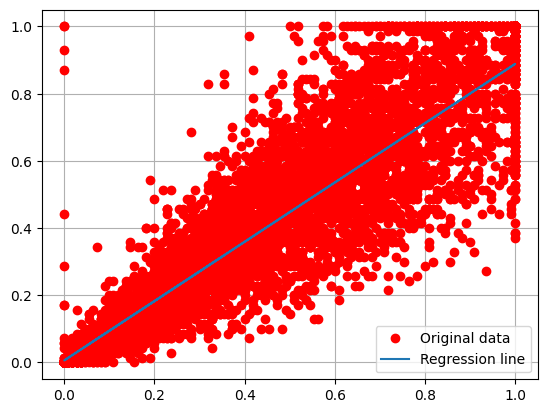

In [28]:
#Plot the model
fig, ax = plt.subplots()
ax.plot(X_sports, y_sports, 'ro', label='Original data')

line, = ax.plot(X_sports, model.predict(X_sports), label='Regression line')

ax.legend()
plt.grid()
plt.show()

### Polynomial Regression

Set the y value to the target variable and X to the features.

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = sports[['home_attack_efficiency',
            'away_attack_efficiency', 
            'home_shot_conversion_rate', 
            'away_shot_conversion_rate']]

y = sports['goals_remaining']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test_poly)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


MSE: 0.009942391751412795
RMSE: 0.0997115427190493
R-squared: 0.7140258218564752


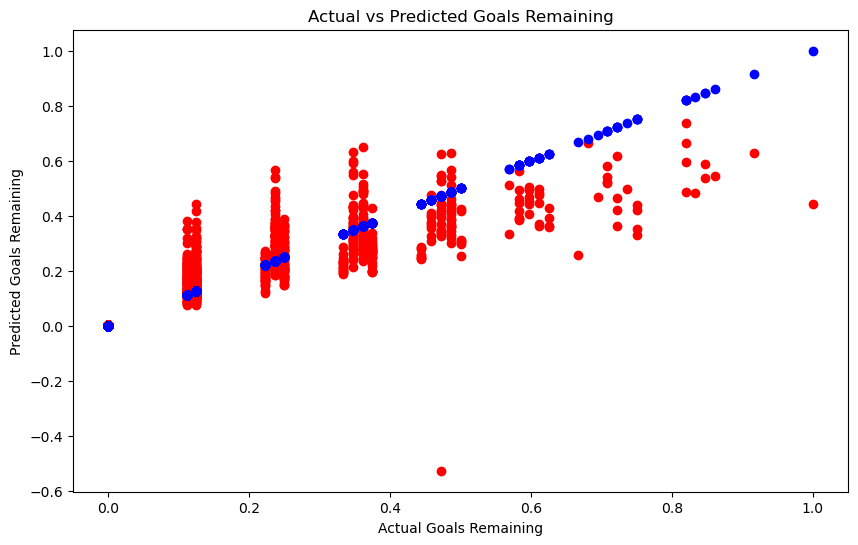

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color='red', label='Predicted') 
plt.scatter(y_test, y_test, color='blue', label='Actual')

plt.xlabel('Actual Goals Remaining')
plt.ylabel('Predicted Goals Remaining')
plt.title('Actual vs Predicted Goals Remaining')

plt.show()

## Error Analysis

## Improving Model

## Model Selection

## Insights and Conclusions

## Reference